In [39]:
import eagleSqlTools as est
import numpy as np
import matplotlib.colors
import astropy.units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation
import matplotlib.pyplot as plt
import healpy as hp
from mpl_toolkits import mplot3d

In [40]:
conn = est.connect("lzm898", "YB854nic", "http://virgodb.dur.ac.uk:8080/MyMillennium")

In [41]:
##Let us do another constraint, mstars_bulge+mstars_disk>=10^7

In [42]:
query3="SELECT gal.x, gal.y, gal.z, halo.m200_crit FROM McAlpine2022a..galaxy as gal, McAlpine2022a..halo as halo WHERE mstars_disk+mstars_bulge >1e7 AND gal.hosthaloid=halo.hosthaloid AND gal.rank=0"

In [43]:
res3=est.execute_query(conn, query3)

In [44]:
#check
print(res3)

[(-164.67422  ,  -72.37616, -82.49002 , 9.20239929e+07)
 (-156.6246   ,  -68.01108, -93.13391 , 1.95550985e+08)
 (-121.58865  , -147.27335,  23.488708, 2.07053984e+08) ...
 (  15.280548 ,   71.99289,  23.819824, 8.51221934e+08)
 (  15.142181 ,  171.51614, -79.79257 , 8.51221934e+08)
 (  14.5686035,  150.8563 , -70.91431 , 8.51221934e+08)]


In [45]:
np.save('res3.npy', res3)

In [46]:
xyzm3 = np.load('res3.npy')

In [47]:
xyzm3=sorted(xyzm3, key=lambda x:np.sqrt(x[0]**2+x[1]**2+x[2]**2))

In [48]:
s3=len(xyzm3)

In [49]:
N=len(xyzm3)
dist=np.zeros(N)
dist_vec=np.zeros((s3,3))
m_halo=np.zeros(s3)
for i in range(N):
    dist[i]=np.sqrt(xyzm3[i][0]**2+xyzm3[i][1]**2+xyzm3[i][2]**2)#Finding distances of different dark matter halos from Milkey way
    dist_vec[i]=np.array([xyzm3[i][0], xyzm3[i][1], xyzm3[i][2]])
    m_halo[i]=xyzm3[i][3]

In [50]:
m=16
j=np.zeros(m, dtype=int)
steps=[21, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
steps1=[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
for i in range(s3):
    if dist[i]>=steps[0]:
        start=i
        break
print(dist[i])
for k in range(1,m+1):
    while dist[i]  < steps[k]:
        j[k-1]+=1 # in j array we keep the number of galaxies corresponding to the relevan shell
        i+=1
        if i > s3-1:
            break
            #if k==9:
               #print(9)

21.00239685826245


In [51]:
print(j)

[ 29799  21522  36709  54964  58047  71853  91349 112687 139253 168335
 175494 197010 231107 251436 262758 296593]


In [52]:
G=6.67*10**(-11)

In [53]:
ac_vec=[[]]*m
ac_scal=[[]]*m
for i in range(m):
    ac_vec[i]=np.zeros((j[i],3))
    ac_scal[i]=np.zeros(j[i])

In [54]:
print(len(ac_vec[1]))

21522


In [55]:
scale=1.99*10**30/(3.08*10**22)**2

In [56]:
i=start
for k in range(1,m+1):
    p=0
    while dist[i]  <= steps[k]:
        ac_vec[k-1][p]=(G*m_halo[i]*scale/dist[i]**3)*dist_vec[i] #in m/s^2
        i+=1
        p+=1
        ac_scal[k-1][p-1]=np.linalg.norm(ac_vec[k-1][p-1])
        if i>s3-1:
            break
    #print(ac_scal[k-1][p-1])

In [57]:
#calculating mean and standard veviation

In [58]:
mean_val=np.zeros(m)
st_dev=np.zeros(m)

In [59]:
#print(mean_val[i])
#print(mean_valnorm)

In [60]:
print(ac_vec[1])

[[ 3.23796693e-18  3.82715074e-19  2.54126721e-19]
 [ 3.12136596e-19  7.97038599e-19 -3.83000404e-20]
 [-1.29737788e-18 -2.58667724e-19  8.25357656e-20]
 ...
 [ 2.58814840e-19  5.77305850e-19 -2.28771477e-20]
 [-1.42538991e-19  2.29796855e-18  2.37305593e-19]
 [-3.60096608e-19  5.41206755e-19  1.42438753e-21]]


In [61]:
Nside3 = 64
r=0.5
npix3 = hp.nside2npix(Nside3)
bins=hp.nside2npix(Nside3)
pix_indices=[[]]*m
counts=[[]]*m
max_idx=np.zeros(m)
for i in range(m):
    pix_indices[i]=np.zeros(j[i])
    counts[i]=np.zeros(bins)

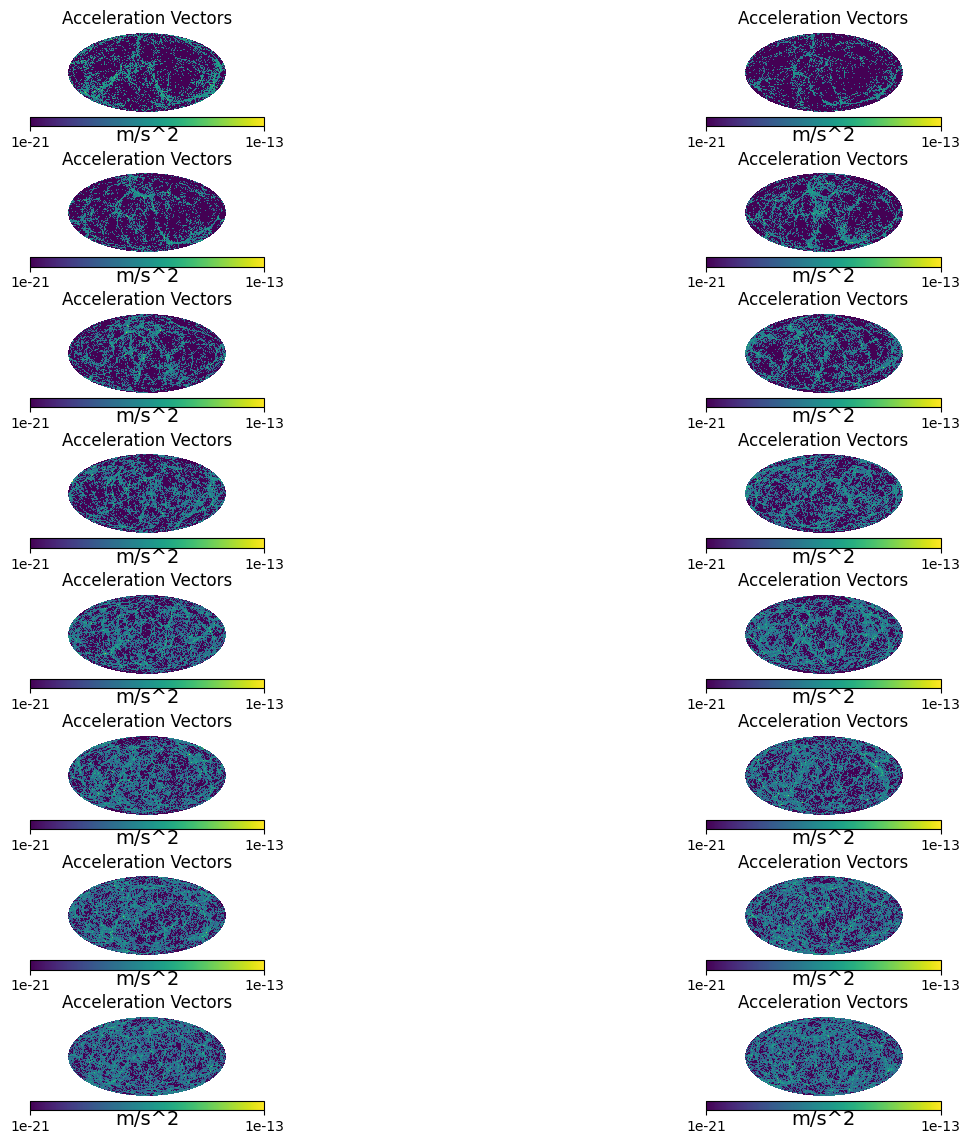

In [62]:
fig, axs = plt.subplots(ncols=2, nrows=8, gridspec_kw={'hspace': 0.5}, figsize=(16,14))
axs = axs.flatten()
for k in range(m):
    pix_indices[k]=hp.pixelfunc.vec2pix(Nside3, list(ac_vec[k][:,0]*u.dimensionless_unscaled),
        list(ac_vec[k][:,1]*u.dimensionless_unscaled),
        list(ac_vec[k][:,2]*u.dimensionless_unscaled))
    counts[k],_=np.histogram(pix_indices[k],bins, weights=ac_scal[k])
    counts[k][counts[k]<=1e-21]=1e-21
    #max_idx[k]=argmax(counts[k])
    mean_val[k]=np.sum(counts[k])/bins
    st_dev[k]=np.sqrt(np.sum((counts[k]-mean_val[k])**2)/bins)
    plt.axes(axs[k])
    hp.mollview(counts[k], norm=matplotlib.colors.LogNorm(), min=1e-21, max=1e-13, title='Acceleration Vectors', unit='m/s^2', badcolor="white",hold=True)
    #plt.plot(mean_valnorm[k][0]*r, mean_valnorm[k][1]*r, color='r', marker='o')
plt.show()

    #print(counts[k])
    #print(pix_indices[k])

In [63]:
#check
#mean_val[1]
np.sum((counts[1]-mean_val[1])**2)
print(ac_vec[1])

[[ 3.23796693e-18  3.82715074e-19  2.54126721e-19]
 [ 3.12136596e-19  7.97038599e-19 -3.83000404e-20]
 [-1.29737788e-18 -2.58667724e-19  8.25357656e-20]
 ...
 [ 2.58814840e-19  5.77305850e-19 -2.28771477e-20]
 [-1.42538991e-19  2.29796855e-18  2.37305593e-19]
 [-3.60096608e-19  5.41206755e-19  1.42438753e-21]]


In [64]:
# calculate pixel size:
pixel_size=4*3.14/(12*Nside3**2)
#in square degrees
print(pixel_size)

0.00025553385416666666


In [65]:
#Now let us calculate acceleration theoretically by omega matter
rho_matter= 2.2*10**(-27) #kg/m^3
steps2=np.array(steps1)
r=steps2*3.08*10**22
print(steps1)
r=np.array(r)
dr=10*3.08*10**22
m_shell=r**2*dr*pixel_size*rho_matter
acceleration=m_shell*G/(r**2)
print(m_shell*G)
print(r**2)
print(acceleration)
##we got that acceleration coinsides more or less than mean value 1-^-16

[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[2.7389816223802086e+31 3.9441335362275014e+31 5.368403979865209e+31
 7.011792953293334e+31 8.874300456511876e+31 1.0955926489520834e+32
 1.3256671052320211e+32 1.5776534144910005e+32 1.8515515767290213e+32
 2.1473615919460835e+32 2.4650834601421872e+32 2.8047171813173335e+32
 3.1662627554715217e+32 3.54972018260475e+32 3.955089462717022e+32
 4.382370595808334e+32]
[2.3716000000000004e+48 3.415104000000001e+48 4.6483360000000006e+48
 6.071296e+48 7.683984e+48 9.486400000000002e+48 1.1478544000000003e+49
 1.3660416000000004e+49 1.6032016000000005e+49 1.8593344000000002e+49
 2.1344399999999996e+49 2.4285184e+49 2.741569600000001e+49 3.0735936e+49
 3.424590400000001e+49 3.7945600000000007e+49]
[1.1549087630208332e-17 1.1549087630208334e-17 1.1549087630208332e-17
 1.1549087630208334e-17 1.1549087630208334e-17 1.1549087630208332e-17
 1.1549087630208334e-17 1.1549087630208334e-17 1.1549087630208332e-17
 1.15490876302

In [66]:
# check
print(mean_val[1], counts[1])
print(np.sum((counts[1]-mean_val[1])**2))

3.786900947711398e-18 [5.40446103e-18 1.00000000e-21 1.00000000e-21 ... 1.00000000e-21
 1.24393010e-17 1.03531927e-18]
6.627850038749549e-28


In [67]:
# check
for k in range (m):
    st_dev[k]=np.sqrt(np.sum((counts[k]-mean_val[k])**2)/bins)
    #print (np.sqrt(np.sum((counts[k]-mean_val[k])**2)/bins))
print(st_dev)  

[5.32006405e-16 1.16122330e-16 1.06610577e-16 3.65474610e-16
 6.81165353e-17 3.67079235e-17 1.12481957e-16 4.79218528e-17
 5.71506471e-17 5.40063808e-17 7.80680869e-17 6.75948824e-17
 5.09206851e-17 4.00114782e-17 4.13265866e-17 2.91161533e-17]


In [68]:
print(st_dev[1])

1.1612232956623046e-16


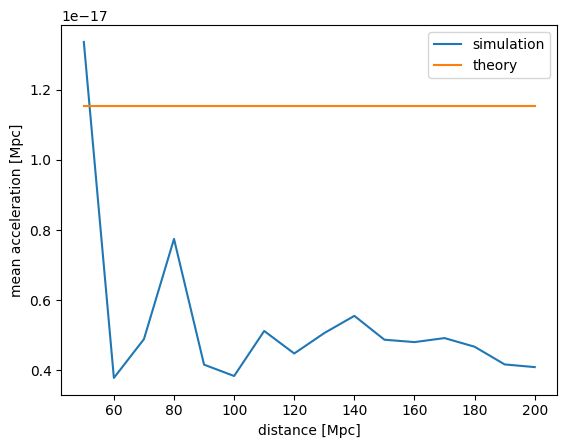

In [69]:
fig,ax=plt.subplots()
plt.plot(steps1, mean_val, label="simulation")
plt.plot(steps1, acceleration, label="theory")
plt.xlabel("distance [Mpc]")
plt.ylabel("mean acceleration [Mpc]")
plt.legend()

Text(0, 0.5, 'standard deviation')

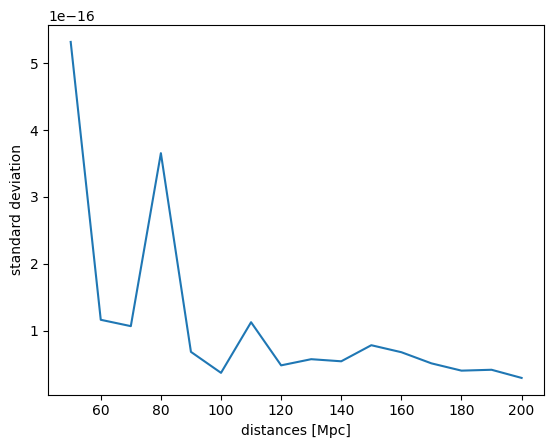

In [79]:
plt.plot(steps1, st_dev)
plt.xlabel("distances [Mpc]")
plt.ylabel("standard deviation")

In [80]:
#cumulative graphs and means

In [72]:
pix_indices2=[[]]*m
counts2=[[]]*m
max_idx2=np.zeros(m)
for i in range(m):
    pix_indices2[i]=np.zeros(j[i])
    counts2[i]=np.zeros(bins)

In [73]:
ac_vec2=[[]]*m
ac_scal2=[[]]*m
s=0
for i in range(m):
    s+=j[i]
    ac_vec2[i]=np.zeros((s,3))
    ac_scal2[i]=np.zeros(s)

In [74]:
i=start
for k in range(1,m+1):
    p=0
    i=start
    while dist[i]  < steps[k]:
        ac_vec2[k-1][p]=(G*m_halo[i]*scale/dist[i]**3)*dist_vec[i] #in m/s^2
        i+=1
        p+=1
        ac_scal2[k-1][p-1]=np.linalg.norm(ac_vec2[k-1][p-1])
        if i>s3-1:
            break

In [75]:
mean_val2=np.zeros(m)
st_dev2=np.zeros(m)

In [83]:
x=np.zeros(m);  ra=np.zeros(m)
y=np.zeros(m);  dec=np.zeros(m)
z=np.zeros(m);  phi=np.zeros(m);  phi_pix=np.zeros(m)
norm=np.zeros(m); theta=np.zeros(m); theta_pix=np.zeros(m)
ipix=np.zeros(m, dtype=int)

In [84]:
a=np.zeros(m, dtype=np.ndarray)
print(type(a[1]))

<class 'int'>


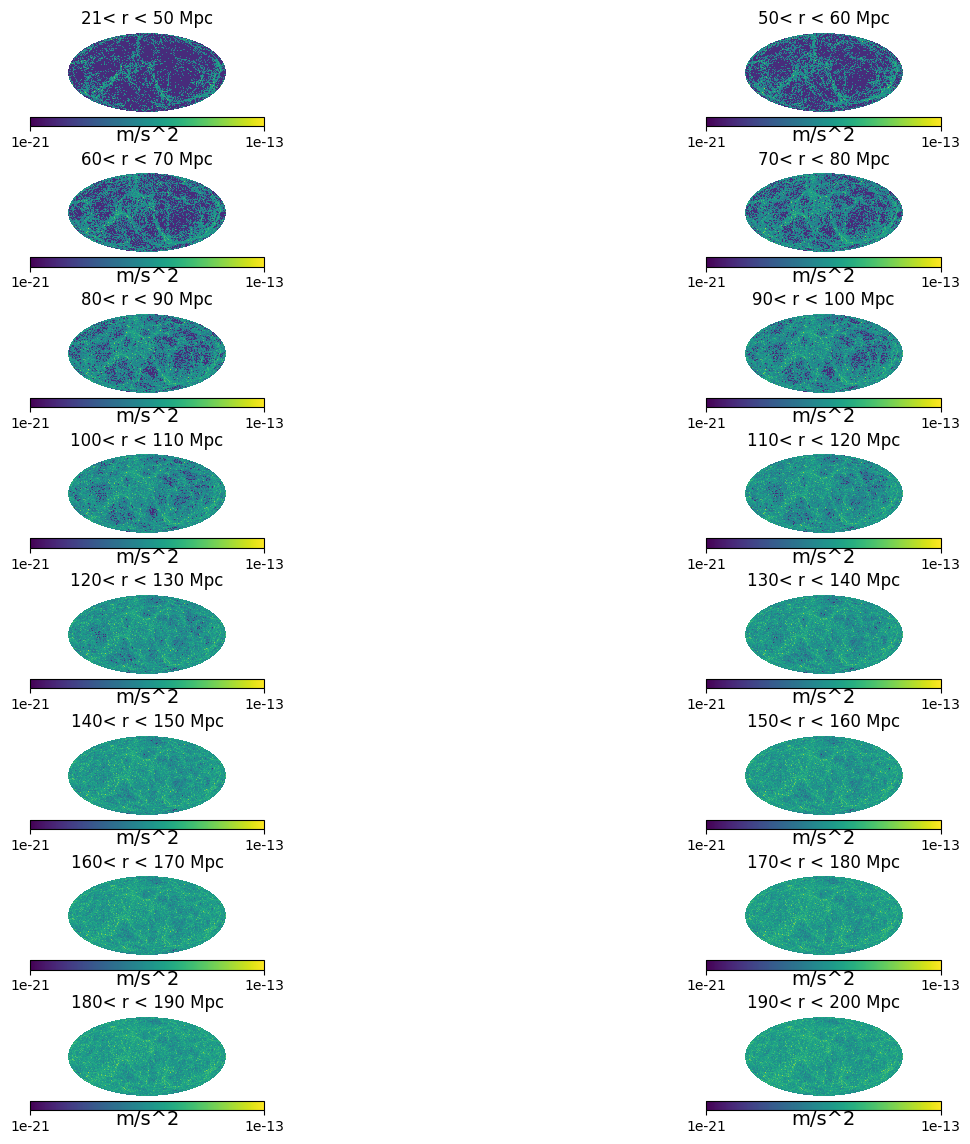

In [88]:
fig, axs = plt.subplots(ncols=2, nrows=8, gridspec_kw={'hspace': 0.5}, figsize=(16,14))
axs = axs.flatten()
for k in range(m):
    pix_indices2[k]=hp.pixelfunc.vec2pix(Nside3, list(ac_vec2[k][:,0]*u.dimensionless_unscaled),
        list(ac_vec2[k][:,1]*u.dimensionless_unscaled),
        list(ac_vec2[k][:,2]*u.dimensionless_unscaled))
    counts2[k],_=np.histogram(pix_indices2[k],bins, weights=ac_scal2[k])
    counts2[k][counts2[k]<=1e-20]=1e-20
    #max_idx[k]=argmax(counts[k])
    plt.axes(axs[k])
    hp.mollview(counts2[k], norm=matplotlib.colors.LogNorm(), min=1e-21, max=1e-13, title=("{}< r < {} Mpc".format(steps[k],steps[k+1])),unit='m/s^2', badcolor="white",hold=True)
    #dec[k] = np.arctan(mean_val2[k][2]/(np.sqrt(mean_val2[k][0]**2+mean_val2[k][1]**2)))
    theta[k] = np.pi/2.0 - dec[k]
    phi[k] = ra[k]
    #ipix[k] = hp.ang2pix(Nside3, theta[k], phi[k])

# Convert ipix to (theta, phi) coordinates
    #theta_pix[k], phi_pix[k] = hp.pix2ang(Nside3, ipix[k], nest=False)

    #hp.mollview(counts2[k], norm=matplotlib.colors.LogNorm(), min=1e-21, max=1e-13 ,unit='m/s^2', badcolor="white",hold=True)
    #hp.projscatter(theta_pix[k]*180.0/np.pi, phi_pix[k]*180.0/np.pi, color='red', s=10)

    #hp.projscatter(ipix[k], lonra=ra[k]*180.0/np.pi, latdec=dec[k]*180/np.pi, c='o', color='red', s=10)
plt.show()

In [ ]:
#check, it is interesting bit I get the same ratio for each 
for k in range(2):
    #print(mean_val2[k])
    print(mean_val2[k][2])
    print((np.arctan(np.sqrt(mean_val2[k][0]**2+mean_val2[k][1]**2))))
    print((mean_val2[k][2]/(np.sqrt(mean_val2[k][0]**2+mean_val2[k][1]**2))))
    

In [ ]:
mean_val2=np.zeros((m,3))
mean_valnorm2=np.zeros((m,3))
mean_scal2=np.zeros(m)
st_dev2=np.zeros(m)
s=0
for i in range(m):
    s+=j[i]
    mean_val2[i]=(np.sum(ac_vec2[i]))/s
    mean_scal2[i]=np.linalg.norm(mean_val2[i])
    mean_valnorm2[i]=mean_val[i]/mean_scal2[i]
    #print(mean_valnorm[i])
    st_dev2[i]=np.sqrt(np.sum((ac_vec2[i]-mean_val2[i])**2)/j[i])

In [ ]:
#Plotting mean acceleration 

In [ ]:
dec = np.arctan(mean_val2[1][2]/(np.sqrt(mean_val2[1][0]**2+mean_val2[1][1]**2)))
theta = np.pi/2.0 - dec
phi = ra
ipix = hp.ang2pix(Nside3, theta, phi)

# Convert ipix to (theta, phi) coordinates
theta_pix, phi_pix = hp.pix2ang(Nside3, ipix, nest=False)

hp.mollview(counts2[1], norm=matplotlib.colors.LogNorm(), min=1e-21, max=1e-13 ,unit='m/s^2', badcolor="white",hold=True)
hp.projscatter(theta_pix*180.0/np.pi, phi_pix*180.0/np.pi, color='red', s=10)

plt.show()


In [ ]:
counts2[1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the vector
v = np.array([1, 2, 3])

# Create the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the starting point of the vector at the origin

# Create a list of x, y, and z values for the vector

# Plot the vector as a line in 3D space
for i in range(m):
    ax.plot([0, mean_val2[i][0]], [0, mean_val2[i][1]], [0,mean_val2[i][2]])


# Set the axes labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the vector
v = np.array([1, 2, 3])

# Create the figure and 3D axis
#fig = plt.figure()
fig, ax = plt.subplots()

# Set the starting point of the vector at the origin

# Create a list of x, y, and z values for the vector

# Plot the vector as a line in 3D space

ax.plot([0, mean_val2[0][0]], [0, mean_val2[0][1]], [0,mean_val2[0][2]])
ax.plot([0, mean_val2[1][0]], [0, mean_val2[1][1]], [0,mean_val2[1][2]])


# Set the axes labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_label('Z')

# Show the plot
plt.show()